# Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb # for modelling
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("data/PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


Plotting the dataframe

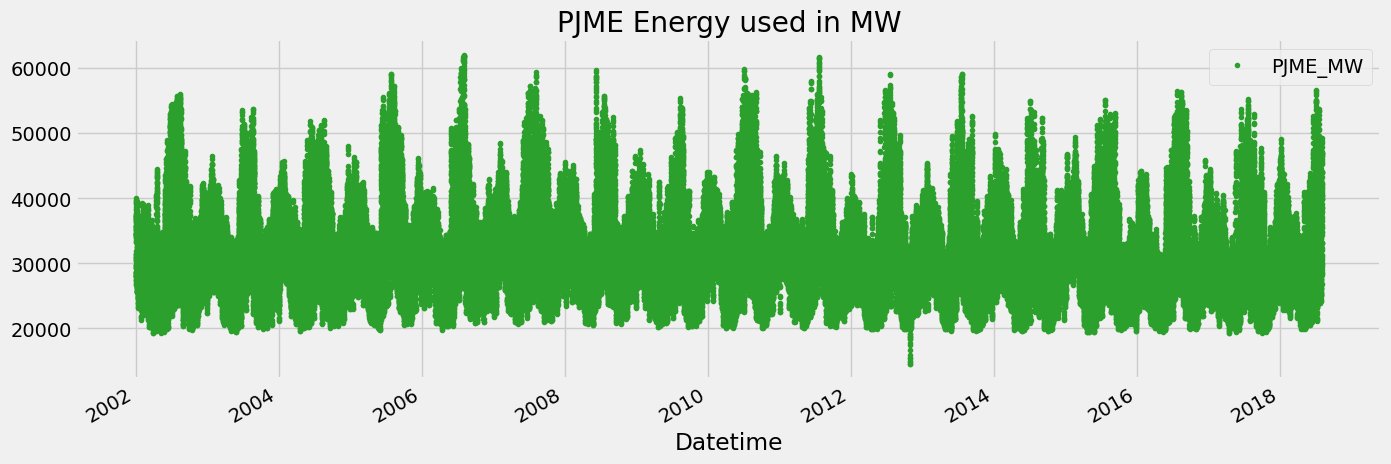

In [3]:
df.plot(style=".",figsize=(15,5), color=color_pal[2],title="PJME Energy used in MW")
plt.show()

## Outline analysis and removal

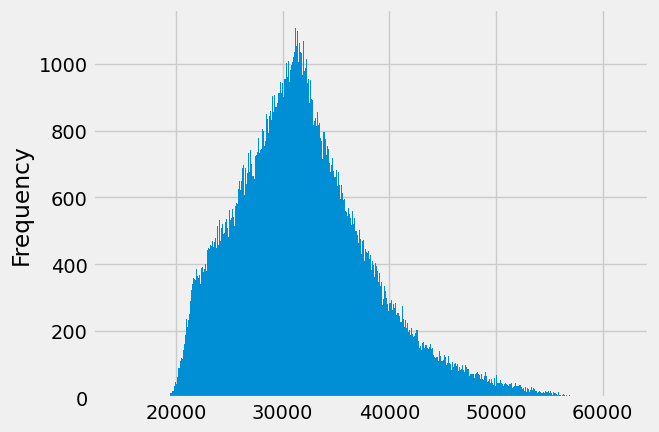

In [4]:
df["PJME_MW"].plot(kind="hist",bins=500)
plt.show()

Looking through the extreme outlayer we want to remove

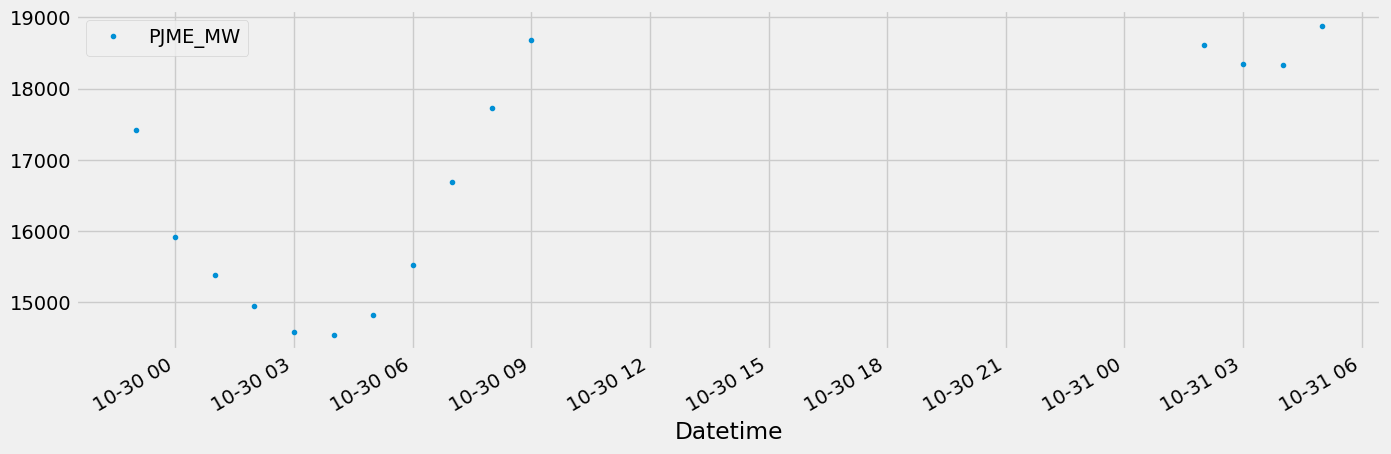

In [5]:
df.loc[df["PJME_MW"]<19000].plot(figsize=(15,5),style=".")
plt.show()

In [6]:
df = df.loc[df["PJME_MW"]>19000].copy()

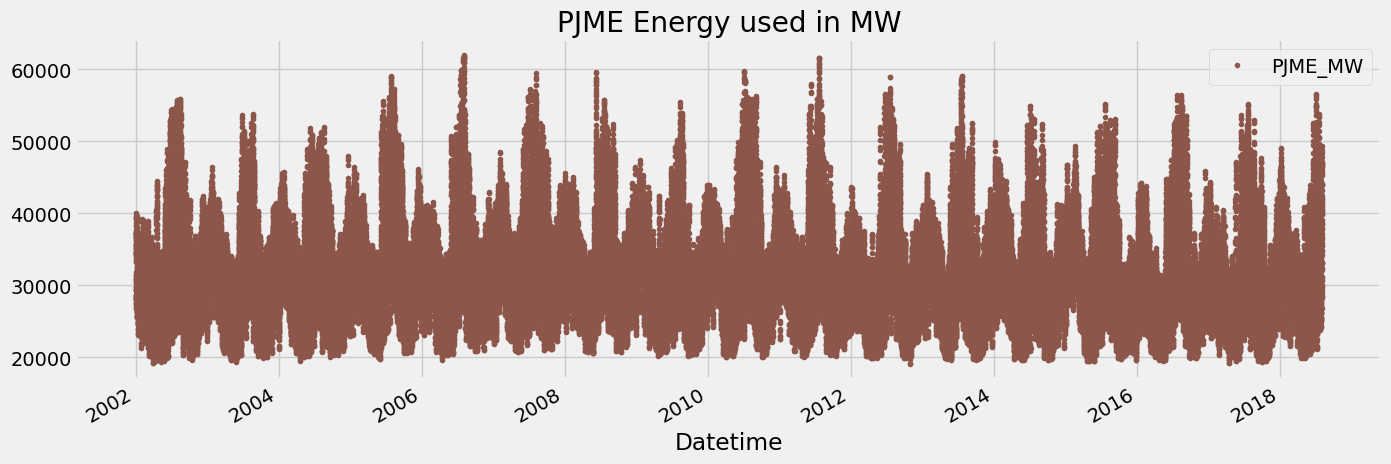

In [7]:
df.plot(style=".",figsize=(15,5), color=color_pal[5],title="PJME Energy used in MW")
plt.show()

# Train / Test Split

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145351 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


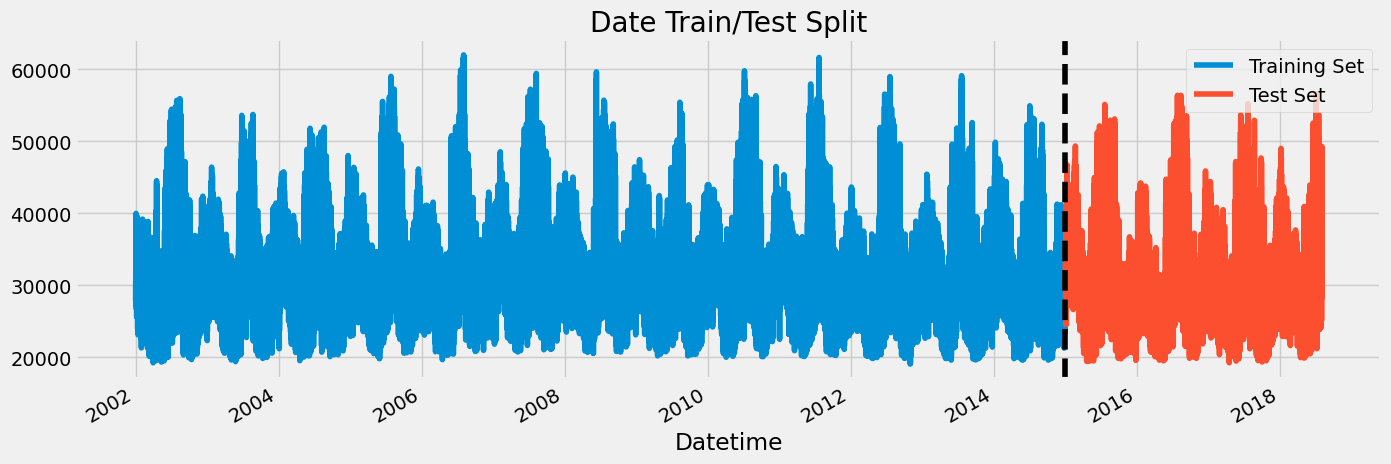

In [9]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title="Date Train/Test Split")
test.plot(ax=ax, label= "Testing Set")
ax.axvline('01-01-2015',color= 'black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

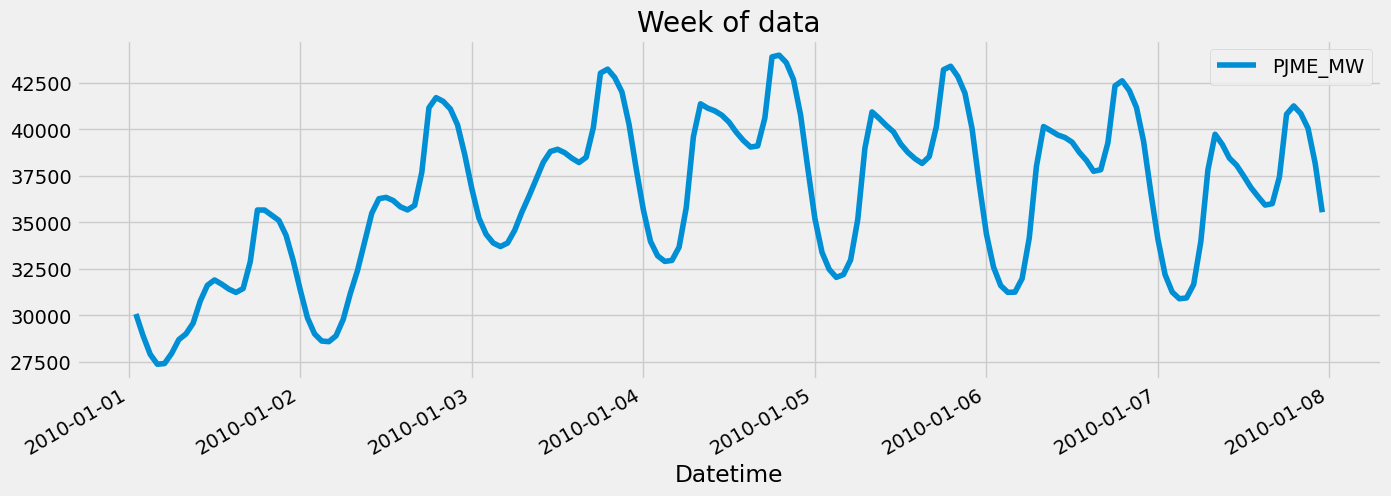

In [10]:
df[(df.index > '01-01-2010') & (df.index <'01-08-2010')].plot(figsize=(15,5), title='Week of data')
plt.show()

## Feature creation

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear']=df.index.dayofyear
    df['dayofmonth'] = df.index.day

    return df
df = create_features(df)

## Visualize our feature / target relationship
One of the method to visualize the relationship is by using seaborne's boxplot. That basically provides the distribution amoung the dataset.

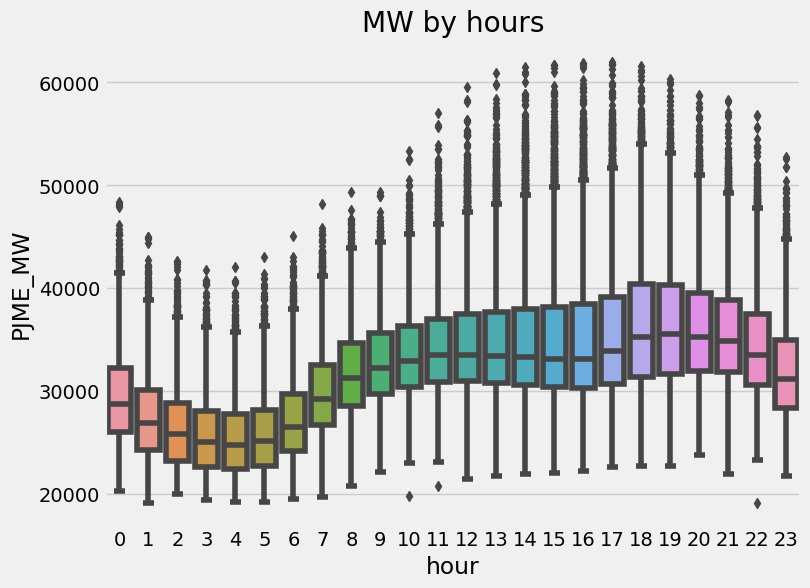

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df, x='hour', y = 'PJME_MW')
ax.set_title('MW by hours')
plt.show()

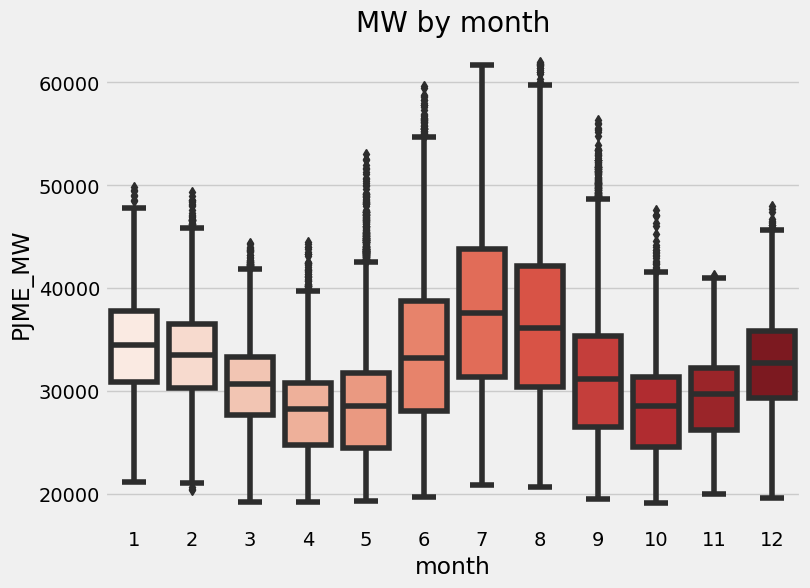

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df, x='month', y = 'PJME_MW',palette='Reds')
ax.set_title('MW by month')
plt.show()

## Create our model
We are going to develop an regression model using XGBoost

In [14]:
train = create_features(train)
test = create_features(test) 
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth']
TARGET = 'PJME_MW'

In [15]:
train.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth'],
      dtype='object')

In [16]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, Y_train, verbose = 100)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [18]:
fi = pd.DataFrame(reg.feature_importances_, index=reg.feature_names_in_,
            columns=["importance"])

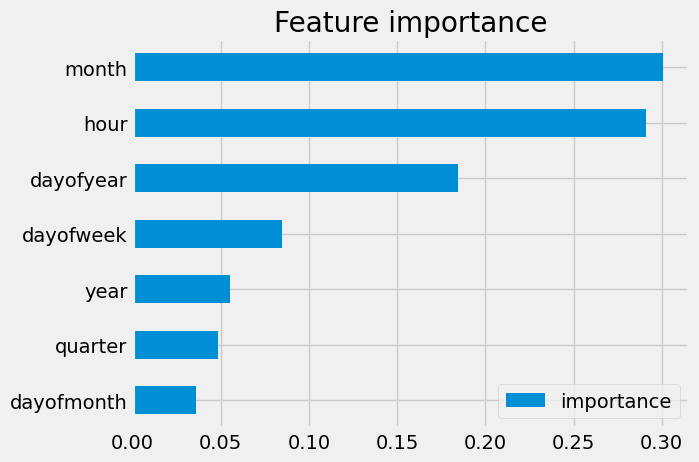

In [19]:
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

## Forecast on test

In [20]:
test['prediction'] = reg.predict(X_test)
df=df.merge(test['prediction'],how="left",left_index=True, right_index=True)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,39744.824219
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,39894.539062
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,38556.953125


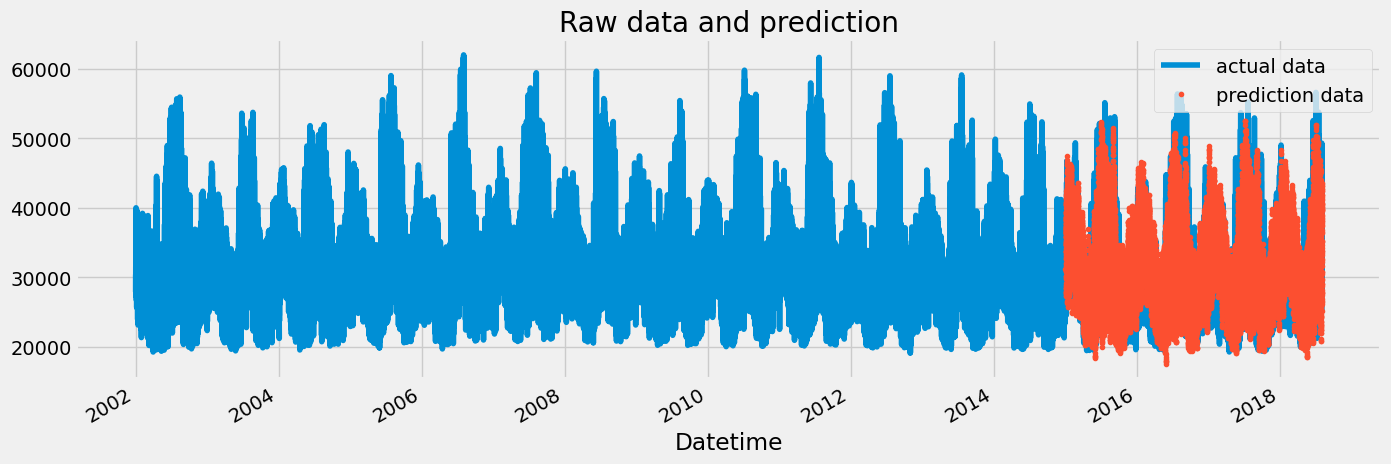

In [21]:
ax = df['PJME_MW'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['actual data','prediction data'])
ax.set_title("Raw data and prediction")
plt.show()

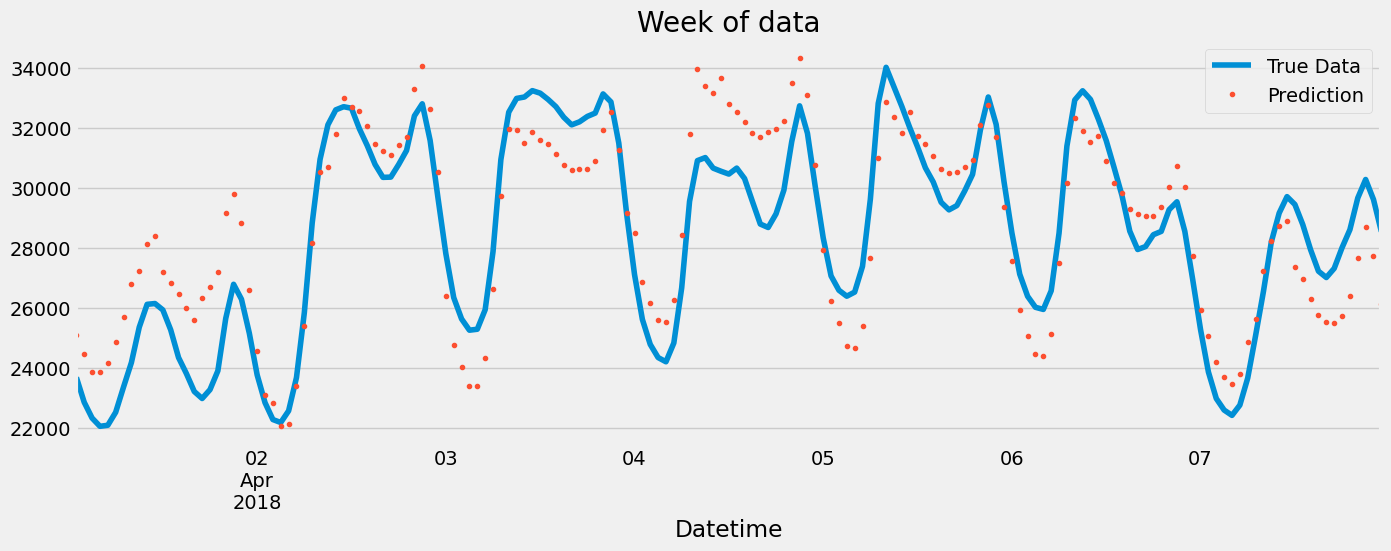

In [22]:
ax = df[(df.index > '04-01-2018') & (df.index <'04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '04-01-2018') & (df.index <'04-08-2018')]['prediction'].plot(style='.')
plt.legend(['True Data','Prediction'])
plt.show()

Calculate score

In [23]:
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE score on Test Set : {score:0.2f}')

RMSE score on Test Set : 4420.24


Calculate error

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [25]:
test['date'] = test.index.date

printing most worst predicted date.

In [26]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-14    17111.597331
2016-08-13    16154.929525
2016-08-12    13209.527425
2017-01-04    13162.537272
2015-02-20    12849.091715
2017-09-02    12126.971680
2016-07-15    12117.474854
2015-02-21    12092.363607
2016-09-10    12085.561361
2017-09-01    11923.263021
Name: error, dtype: float64

printing less more worst predicted date.

In [27]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2015-10-08    182.836995
2015-10-24    187.213542
2016-10-08    240.727539
2016-10-02    263.165690
2017-05-07    270.148844
2016-04-29    284.432699
2015-10-07    318.177734
2015-03-22    324.236654
2016-10-07    333.082601
2015-04-22    335.705241
Name: error, dtype: float64

## next step
- Time Series Cross Validation
- Forecasting Horizon 
- Lag Features
- Predicting the Future

# Time series cross validation

Time series cross validation provide mode rebust model than train and test model.

In [28]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.query('PJME_MW > 19_000').copy()
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [29]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

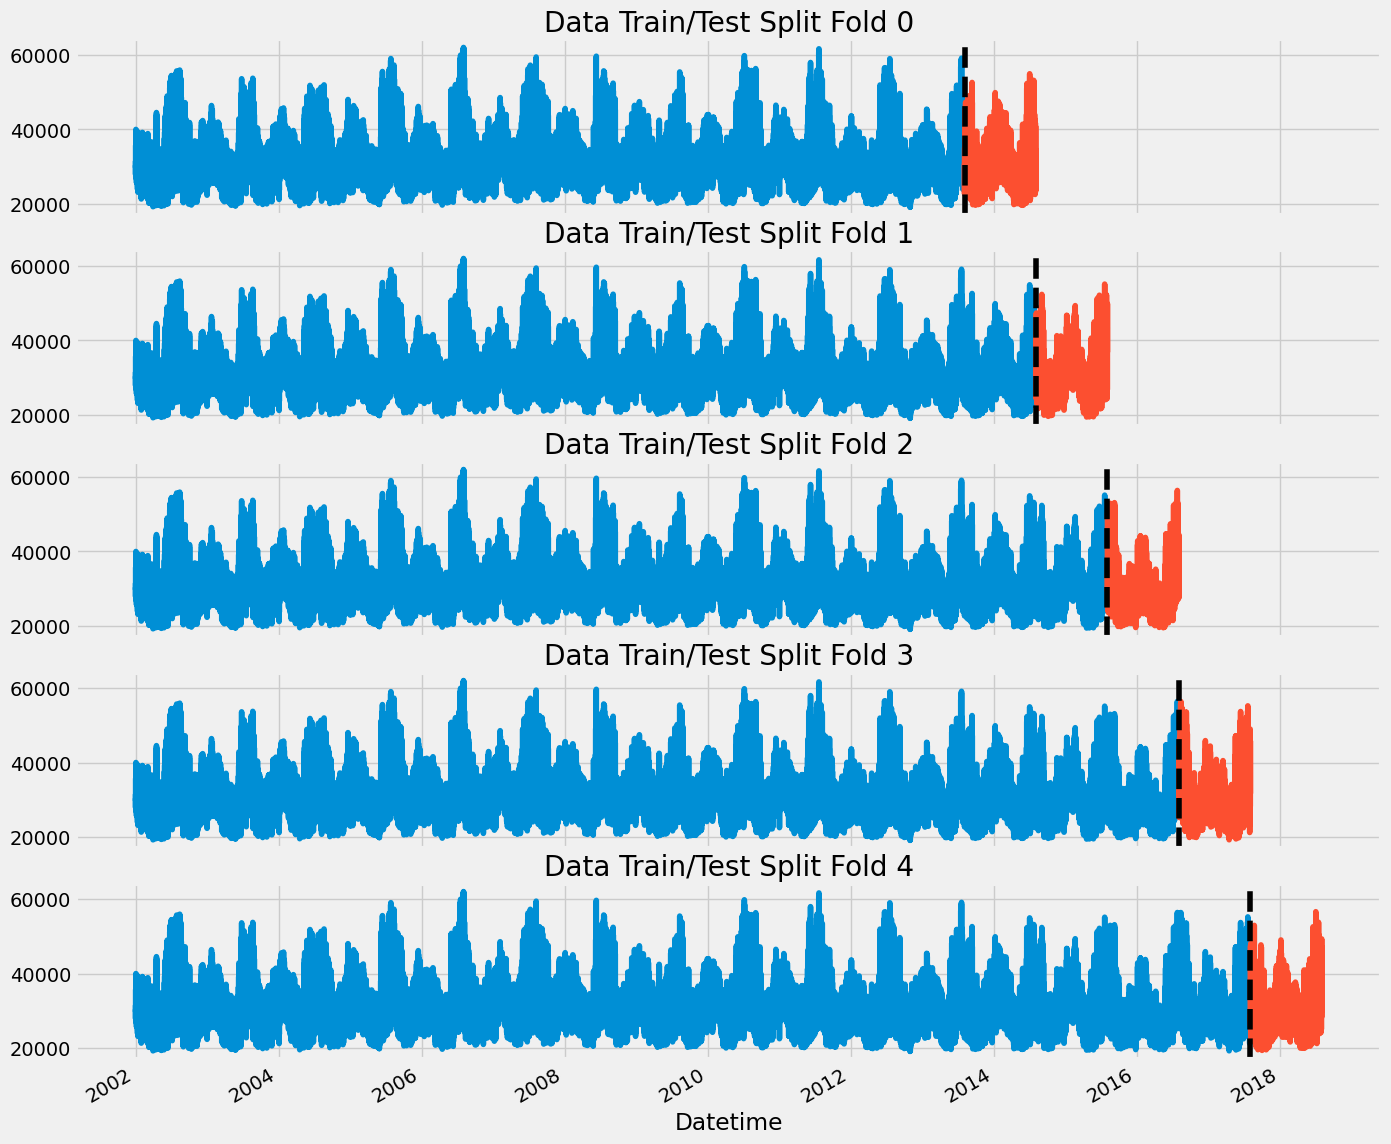

In [30]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [31]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear']=df.index.dayofyear
    df['dayofmonth'] = df.index.day

    return df
df = create_features(df)

# Forecasting Horizon
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

## Creating Lag Features

In [32]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [33]:
df = add_lags(df)

Train Using Cross Validation

In [34]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    Y_train = train[TARGET]
    X_test = test[FEATURES]
    Y_test = test[TARGET]
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, Y_train, verbose = 100)
    Y_pred = reg.predict(X_test)
    preds.append(Y_pred)
    score = np.sqrt(mean_squared_error(Y_test,Y_pred))
    scores.append(score)

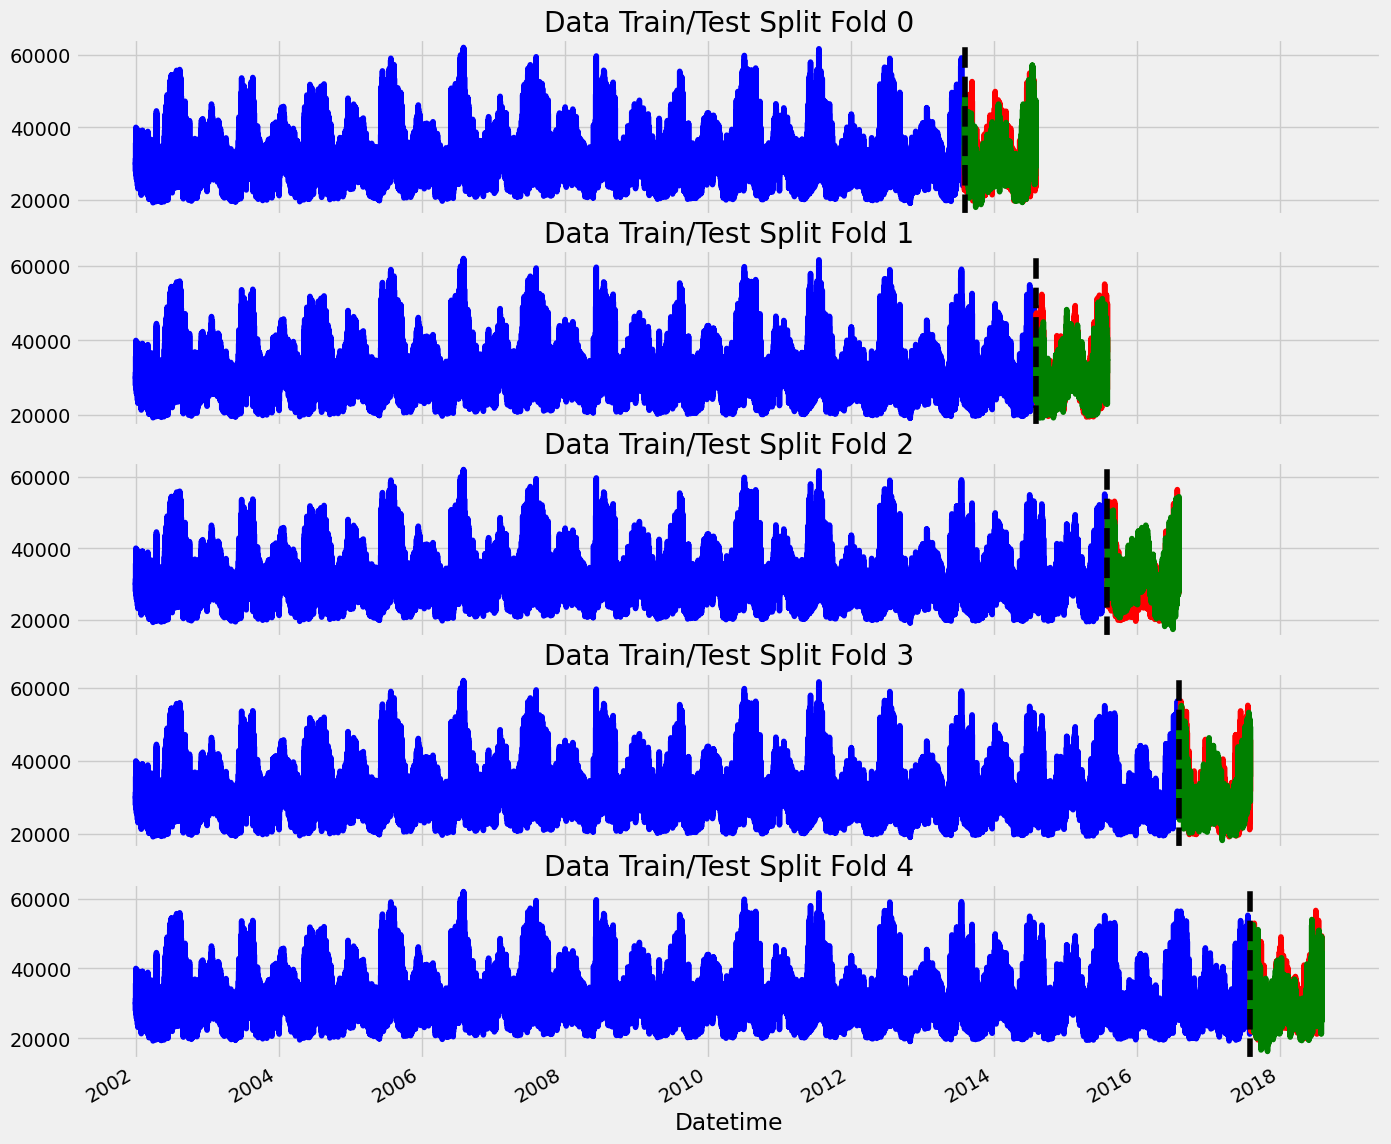

In [36]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',
                          color='blue')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set',color='red')
    pred =  pd.DataFrame(index=test.index)
    pred["PJME_MW"] = preds[fold]
    pred['PJME_MW'].plot(ax=axs[fold],
                         label='prediction Set',color='green')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [37]:
print(f'Score across folds {np.mean(scores):0.3f}')
print(f'Fold scores:{scores}')

Score across folds 4308.594
Fold scores:[4209.526465869029, 3756.931382106531, 4461.802620911124, 4315.988317706051, 4798.721958463723]


# Predicting the Future

In [38]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_all, y_all, verbose = 100)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [40]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [41]:
future_w_features = df_and_future[df_and_future['isFuture']].copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,40666.0,34555.0,34641.0,True


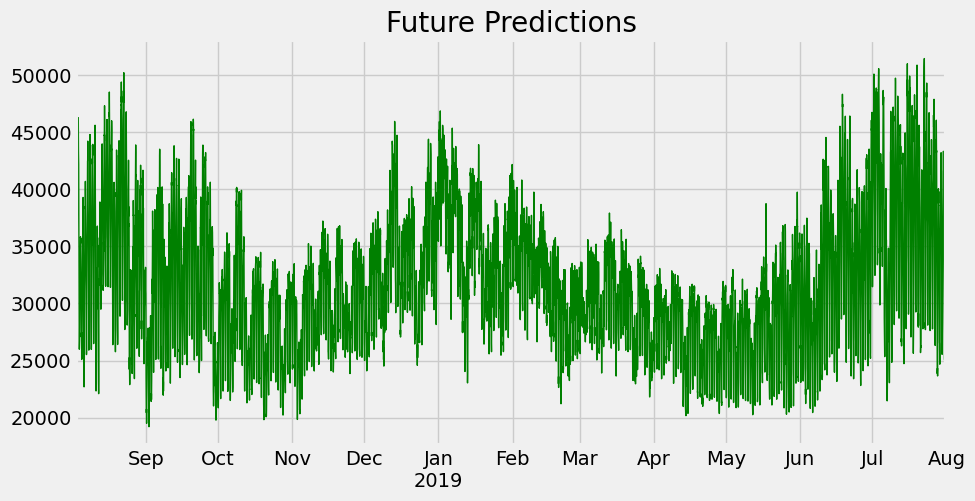

In [42]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),color="green",
                               ms=1,lw=1,title='Future Predictions')
plt.show()

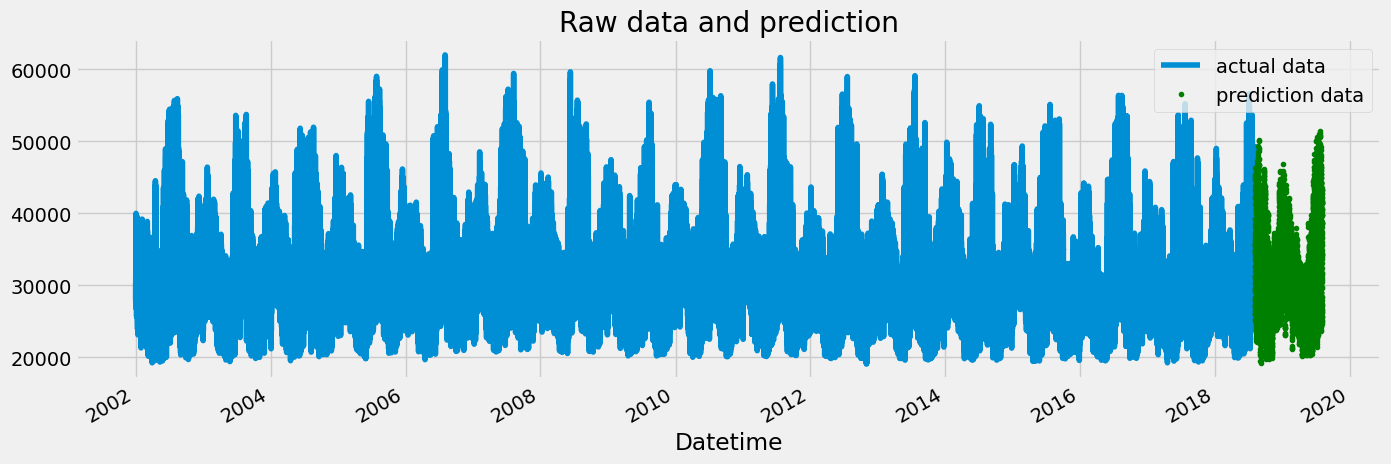

In [43]:
ax = df['PJME_MW'].plot(figsize=(15,5))
future_w_features['pred'].plot(ax=ax, style='.',color="green")
plt.legend(['actual data','prediction data'])
ax.set_title("Raw data and prediction")
plt.show()